# Pattern correlation between NTA/CTI and Z200/OMEGA 

This notebook is to calculate the pattern correlation between NTA and Z200/OMEGA, including the observations, CMIP6, and E3SM models. 

- For Walker circulation, the pattern correlation between NTA and OMEGA is calculated, and the region for pattern correlation is restricted in (120-360).

- For Z200, the pattern correlation between CTI and Z200 is calculated, and the region for pattern correlation is restricted in longittude in (120, 360), latitude in (-60, 60).


## Walker circulation on NTA and CTI first

In [6]:
import xarray as xr
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import numpy as np
from scipy.stats import linregress
from scipy import stats
from itertools import cycle
from cmip_postprocess import load_from_pickle
import cftime
import warnings
warnings.filterwarnings('ignore')

In [7]:
path = '../data/processed/regression/'

reg_nta_omega_cmip = load_from_pickle(path+'regression_omega_ano_nta.pkl')
reg_cti_omega_cmip = load_from_pickle(path+'regression_omega_ano_cti.pkl')

CMIP6_MODLES = '../data/raw/source_id.txt'

In [8]:
def get_input_names(cmip_model=None):
    with open(cmip_model, "r") as f:
        lines = f.readlines()
    return lines

cmip_models = get_input_names(CMIP6_MODLES)

models_extend = ['ERA5', 'E3SM-MMF', 'E3SMv2']

In [9]:

def safe_pearsonr(x, y):
    mask = np.isfinite(x) & np.isfinite(y)
    x_clean = x[mask]
    y_clean = y[mask]
    if len(x_clean) > 1 and len(y_clean) > 1:
        return stats.pearsonr(x_clean, y_clean)[0]
    else:
        return np.nan

    
def calculate_pattern_correlation(models, reg_nta_omega, reg_cti_omega, var='slope'):
    cor_omega = {}
    for model in models:
        model = model.split('.')[0]
        print(f'Processing {model}')
        nta_omega = reg_nta_omega[model][var].values.flatten()
        cti_omega = reg_cti_omega[model][var].values.flatten()
        cor_omega[model] = safe_pearsonr(nta_omega, cti_omega)
    return cor_omega

def calculate_weighted_pattern_correlation(models, reg_nta_omega, reg_cti_omega, var='slope'):
    cor_omega = {}
    for model in models:
        print(f'Processing {model}')
        model = model.split('.')[0]
        # Extract the slope values and latitudes
        nta_omega = reg_nta_omega[model][var].values
        cti_omega = reg_cti_omega[model][var].values
        
        # Get the latitudes (assuming they're the same for both datasets)
        lats = reg_nta_omega[model][var].lat.values
        
        # Calculate latitude weights
        lat_weights = np.cos(np.deg2rad(lats))
        
        # Reshape weights to match the data shape (assuming 2D: lat, lon)
        weights_2d = lat_weights[:, np.newaxis]
        
        # Apply weights and flatten
        nta_omega_weighted = (nta_omega * weights_2d).flatten()
        cti_omega_weighted = (cti_omega * weights_2d).flatten()
        
        # Calculate weighted correlation
        cor_omega[model] = safe_pearsonr(nta_omega_weighted, cti_omega_weighted)
    
    return cor_omega


In [10]:
# Usage:
# Select longitude range 120E to 360E (0E)
lon_mask = (reg_nta_omega_cmip[list(reg_nta_omega_cmip.keys())[0]]['slope'].lon >= 120) & \
           (reg_nta_omega_cmip[list(reg_nta_omega_cmip.keys())[0]]['slope'].lon <= 360)

# Apply longitude mask to both datasets
reg_nta_omega_cmip_masked = {model: data.sel(lon=lon_mask) for model, data in reg_nta_omega_cmip.items()}
reg_cti_omega_cmip_masked = {model: data.sel(lon=lon_mask) for model, data in reg_cti_omega_cmip.items()}

cor_omega = calculate_pattern_correlation(cmip_models, reg_nta_omega_cmip_masked, reg_cti_omega_cmip_masked)
cor_omega_extend = calculate_pattern_correlation(models_extend, reg_nta_omega_cmip_masked, reg_cti_omega_cmip_masked)

cor_omega.update(cor_omega_extend)
# Print results
for model, correlation in cor_omega.items():
    print(f"{model}: correlation = {correlation}")

Processing CESM2-WACCM
Processing CESM2-WACCM-FV2
Processing CESM2-FV2
Processing CESM2
Processing TaiESM1
Processing GISS-E2-1-H
Processing BCC-ESM1
Processing NESM3
Processing GISS-E2-1-G-CC
Processing CanESM5
Processing BCC-CSM2-MR
Processing GISS-E2-1-G
Processing MPI-ESM-1-2-HAM
Processing MPI-ESM1-2-LR
Processing NorESM2-MM
Processing IITM-ESM
Processing MRI-ESM2-0
Processing CMCC-CM2-SR5
Processing FGOALS-g3
Processing ACCESS-CM2
Processing MPI-ESM1-2-HR
Processing CAMS-CSM1-0
Processing AWI-ESM-1-1-LR
Processing CMCC-ESM2
Processing SAM0-UNICON
Processing MIROC6
Processing CMCC-CM2-HR4
Processing ERA5
Processing E3SM-MMF
Processing E3SMv2
CESM2-WACCM: correlation = 0.4860604676104901
CESM2-WACCM-FV2: correlation = 0.4857699340719486
CESM2-FV2: correlation = 0.820129064646805
CESM2: correlation = 0.3841509417110145
TaiESM1: correlation = 0.6337018885351666
GISS-E2-1-H: correlation = 0.7765184095765036
BCC-ESM1: correlation = 0.2514795584710864
NESM3: correlation = 0.825492752451

In [11]:
# calculate CMIP6-MMM correlation and standard deviation
cmip_cors = [cor for model, cor in cor_omega.items() if model != 'ERA5']
cmip_mmm_cor = np.mean(cmip_cors)
cmip_std_cor = np.std(cmip_cors)
cor_omega['CMIP6-MMM'] = cmip_mmm_cor
print(f"CMIP6-MMM correlation = {cmip_mmm_cor:.3f} ± {cmip_std_cor:.3f}")


CMIP6-MMM correlation = 0.499 ± 0.382


In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pattern_correlations(cor_omega, x_label='Pattern Correlation Coefficient between OMEGA-NTA vs. OMEGA-CTI'):
   
    # plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 12
    
    cor_omega_normalized = {k.upper(): v for k, v in cor_omega.items()}

    highlighted_models = ['ERA5', 'CMIP6-MMM', 'E3SM-MMF', 'E3SMV2']
    other_models = [model for model in cor_omega_normalized.keys() if model not in highlighted_models]

    other_models_sorted = sorted(other_models, key=lambda x: cor_omega_normalized.get(x, 0), reverse=True)
    all_models = highlighted_models + other_models_sorted

    models = []
    correlations = []
    colors = []


    cmip_cors = [cor for model, cor in cor_omega_normalized.items() 
                 if model not in ['ERA5', 'CMIP6-MMM', 'E3SM-MMF', 'E3SMV2']]
    cmip_std = np.std(cmip_cors)

    for model in all_models:
        if model in cor_omega_normalized:
            correlation = cor_omega_normalized[model]
            models.append(model)
            correlations.append(correlation)

            colors.append('#D55E00' if correlation < 0 else '#0072B2')


    fig, ax = plt.subplots(figsize=(8, len(models) * 0.4), dpi=300)
    y_pos = np.arange(len(models))
    

    bars = ax.barh(y_pos, correlations, align='center', color=colors, height=0.6)
    

    mmm_idx = models.index('CMIP6-MMM')
    ax.errorbar(correlations[mmm_idx], y_pos[mmm_idx], 
               xerr=cmip_std, color='black', 
               capsize=4, capthick=1.2, 
               fmt='none', elinewidth=1.2)


    ax.set_yticks(y_pos)
    ax.set_yticklabels(models, fontsize=10,)
    ax.invert_yaxis()
    ax.set_xlabel(x_label, fontsize=12, fontweight='bold')
    

    ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)


    ax.grid(True, axis='x', linestyle=':', alpha=0.4, color='gray')


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
   
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)

  
    ax.tick_params(axis='both', direction='out', length=4, width=1.2)


    plt.tight_layout()
    plt.show()

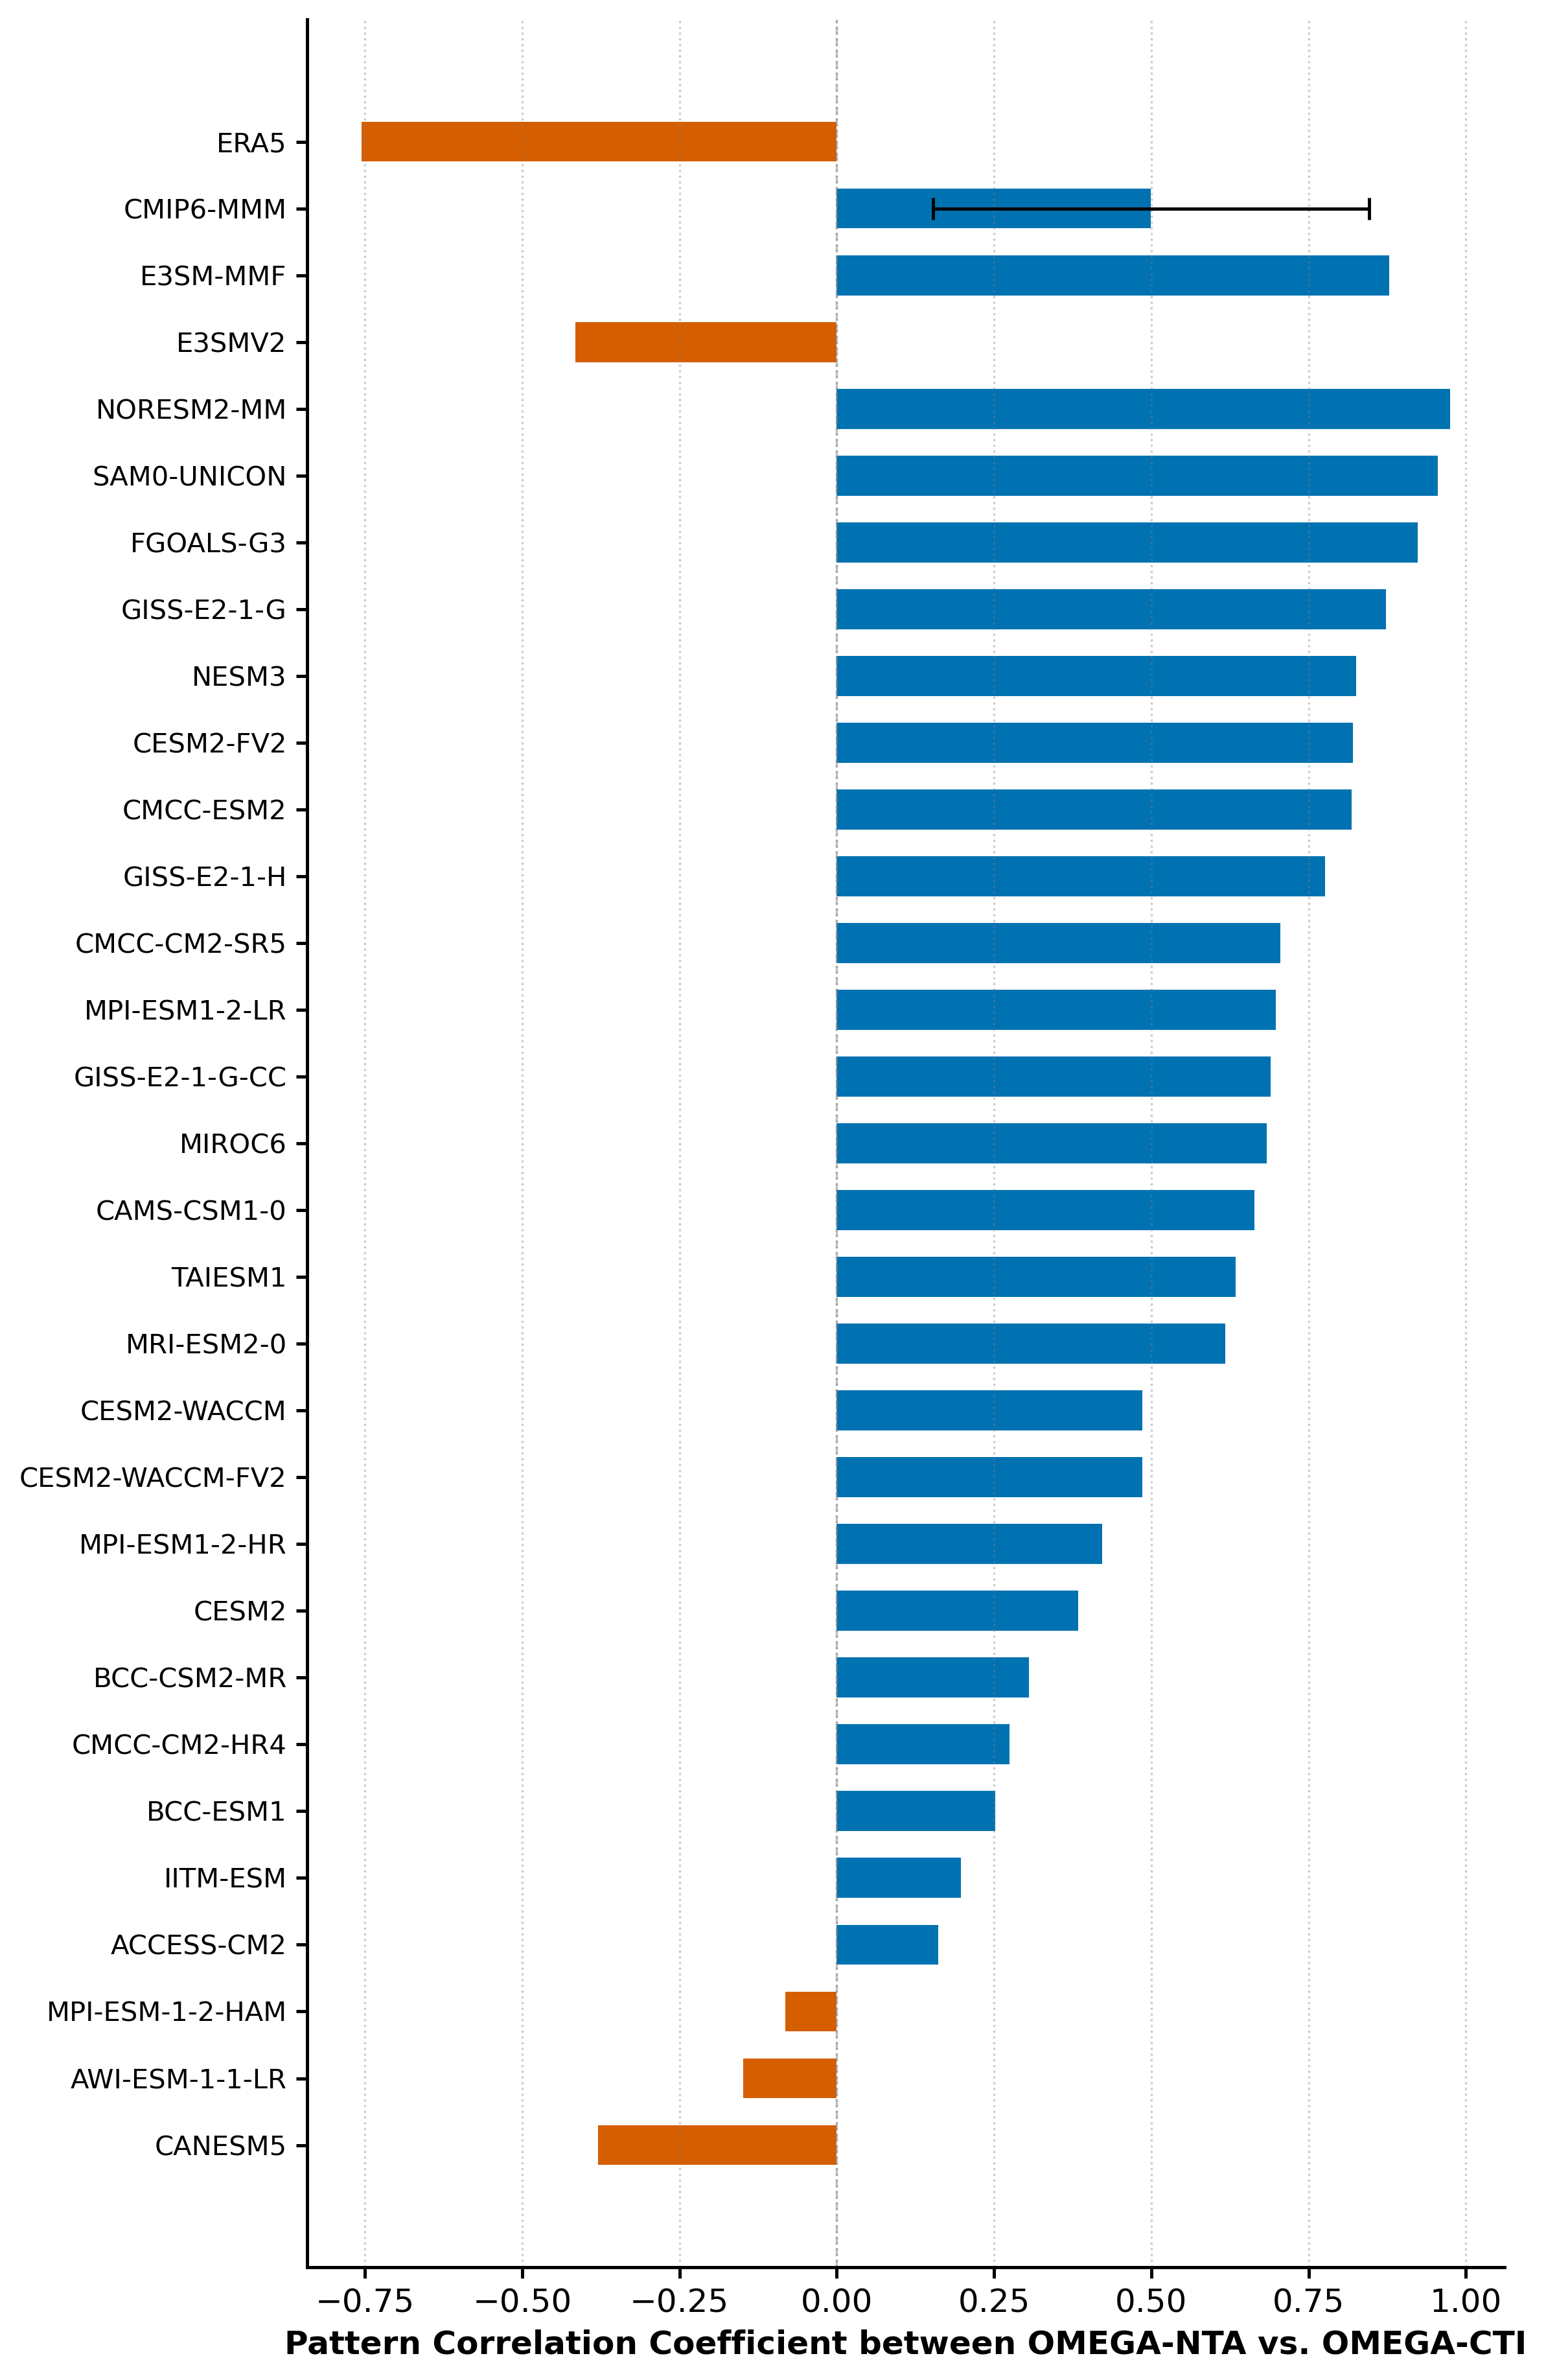

In [13]:
plot_pattern_correlations(cor_omega)

## Pattern correlation for Z200

In [14]:
path = '../data/processed/regression/'


reg_nta_z200_cmip = load_from_pickle(path+'reg_nta_z200_cmip.pkl')
reg_cti_z200_cmip = load_from_pickle(path+'reg_cti_z200_cmip.pkl')

reg_nta_z200_2 = load_from_pickle(path+'reg_nta_z200_e3sm.pkl')
reg_cti_z200_2 = load_from_pickle(path+'reg_cti_z200_e3sm.pkl')



In [15]:
def get_input_names(cmip_model=None):
    with open(cmip_model, "r") as f:
        lines = f.readlines()
    return lines

cmip_models = get_input_names(CMIP6_MODLES)

models_extend = ['ERA5', 'E3SM-MMF', 'E3SMv2']

In [16]:

reg_nta_z200_dict = {}
reg_cti_z200_dict = {}


for i, model in enumerate(cmip_models):
    model = model.split('.')[0]  
    reg_nta_z200_dict[model] = reg_nta_z200_cmip[i]
    reg_cti_z200_dict[model] = reg_cti_z200_cmip[i]


reg_nta_z200_cmip = reg_nta_z200_dict
reg_cti_z200_cmip = reg_cti_z200_dict




In [17]:
reg_nta_z200_2_dict = {}
reg_cti_z200_2_dict = {}

for i, model in enumerate(models_extend):
    model = model.split('.')[0]  # 移除换行符
    reg_nta_z200_2_dict[model] = reg_nta_z200_2[i]
    reg_cti_z200_2_dict[model] = reg_cti_z200_2[i]

reg_nta_z200_2 = reg_nta_z200_2_dict
reg_cti_z200_2 = reg_cti_z200_2_dict


In [18]:

reg_nta_z200_filtered = {}
for model, data in reg_nta_z200_cmip.items():
    reg_nta_z200_filtered[model] = data.sel(lat=slice(-60, 60), lon=slice(120, 360))

reg_cti_z200_filtered = {}
for model, data in reg_cti_z200_cmip.items():
    reg_cti_z200_filtered[model] = data.sel(lat=slice(-60, 60), lon=slice(120, 360))

reg_nta_z200_extend_filtered = {}
for model, data in reg_nta_z200_2.items():
    reg_nta_z200_extend_filtered[model] = data.sel(lat=slice(-60, 60), lon=slice(120, 360))

reg_cti_z200_extend_filtered = {}
for model, data in reg_cti_z200_2.items():
    reg_cti_z200_extend_filtered[model] = data.sel(lat=slice(-60, 60), lon=slice(120, 360))


cor_z200 = calculate_weighted_pattern_correlation(cmip_models, reg_nta_z200_filtered, reg_cti_z200_filtered)
cor_z200_extend = calculate_weighted_pattern_correlation(models_extend, reg_nta_z200_extend_filtered, reg_cti_z200_extend_filtered)


cor_z200.update(cor_z200_extend)

Processing CESM2-WACCM.gn.historical.Amon.r1i1p1f1

Processing CESM2-WACCM-FV2.gn.historical.Amon.r1i1p1f1

Processing CESM2-FV2.gn.historical.Amon.r1i1p1f1

Processing CESM2.gn.historical.Amon.r1i1p1f1

Processing TaiESM1.gn.historical.Amon.r1i1p1f1

Processing GISS-E2-1-H.gn.historical.Amon.r1i1p1f1

Processing BCC-ESM1.gn.historical.Amon.r1i1p1f1

Processing NESM3.gn.historical.Amon.r1i1p1f1

Processing GISS-E2-1-G-CC.gn.historical.Amon.r1i1p1f1

Processing CanESM5.gn.historical.Amon.r1i1p1f1

Processing BCC-CSM2-MR.gn.historical.Amon.r1i1p1f1

Processing GISS-E2-1-G.gn.historical.Amon.r1i1p1f1

Processing MPI-ESM-1-2-HAM.gn.historical.Amon.r1i1p1f1

Processing MPI-ESM1-2-LR.gn.historical.Amon.r1i1p1f1

Processing NorESM2-MM.gn.historical.Amon.r1i1p1f1

Processing IITM-ESM.gn.historical.Amon.r1i1p1f1

Processing MRI-ESM2-0.gn.historical.Amon.r1i1p1f1

Processing CMCC-CM2-SR5.gn.historical.Amon.r1i1p1f1

Processing FGOALS-g3.gn.historical.Amon.r1i1p1f1

Processing ACCESS-CM2.gn.histo

CMIP6-MMM correlation = 0.499 ± 0.382


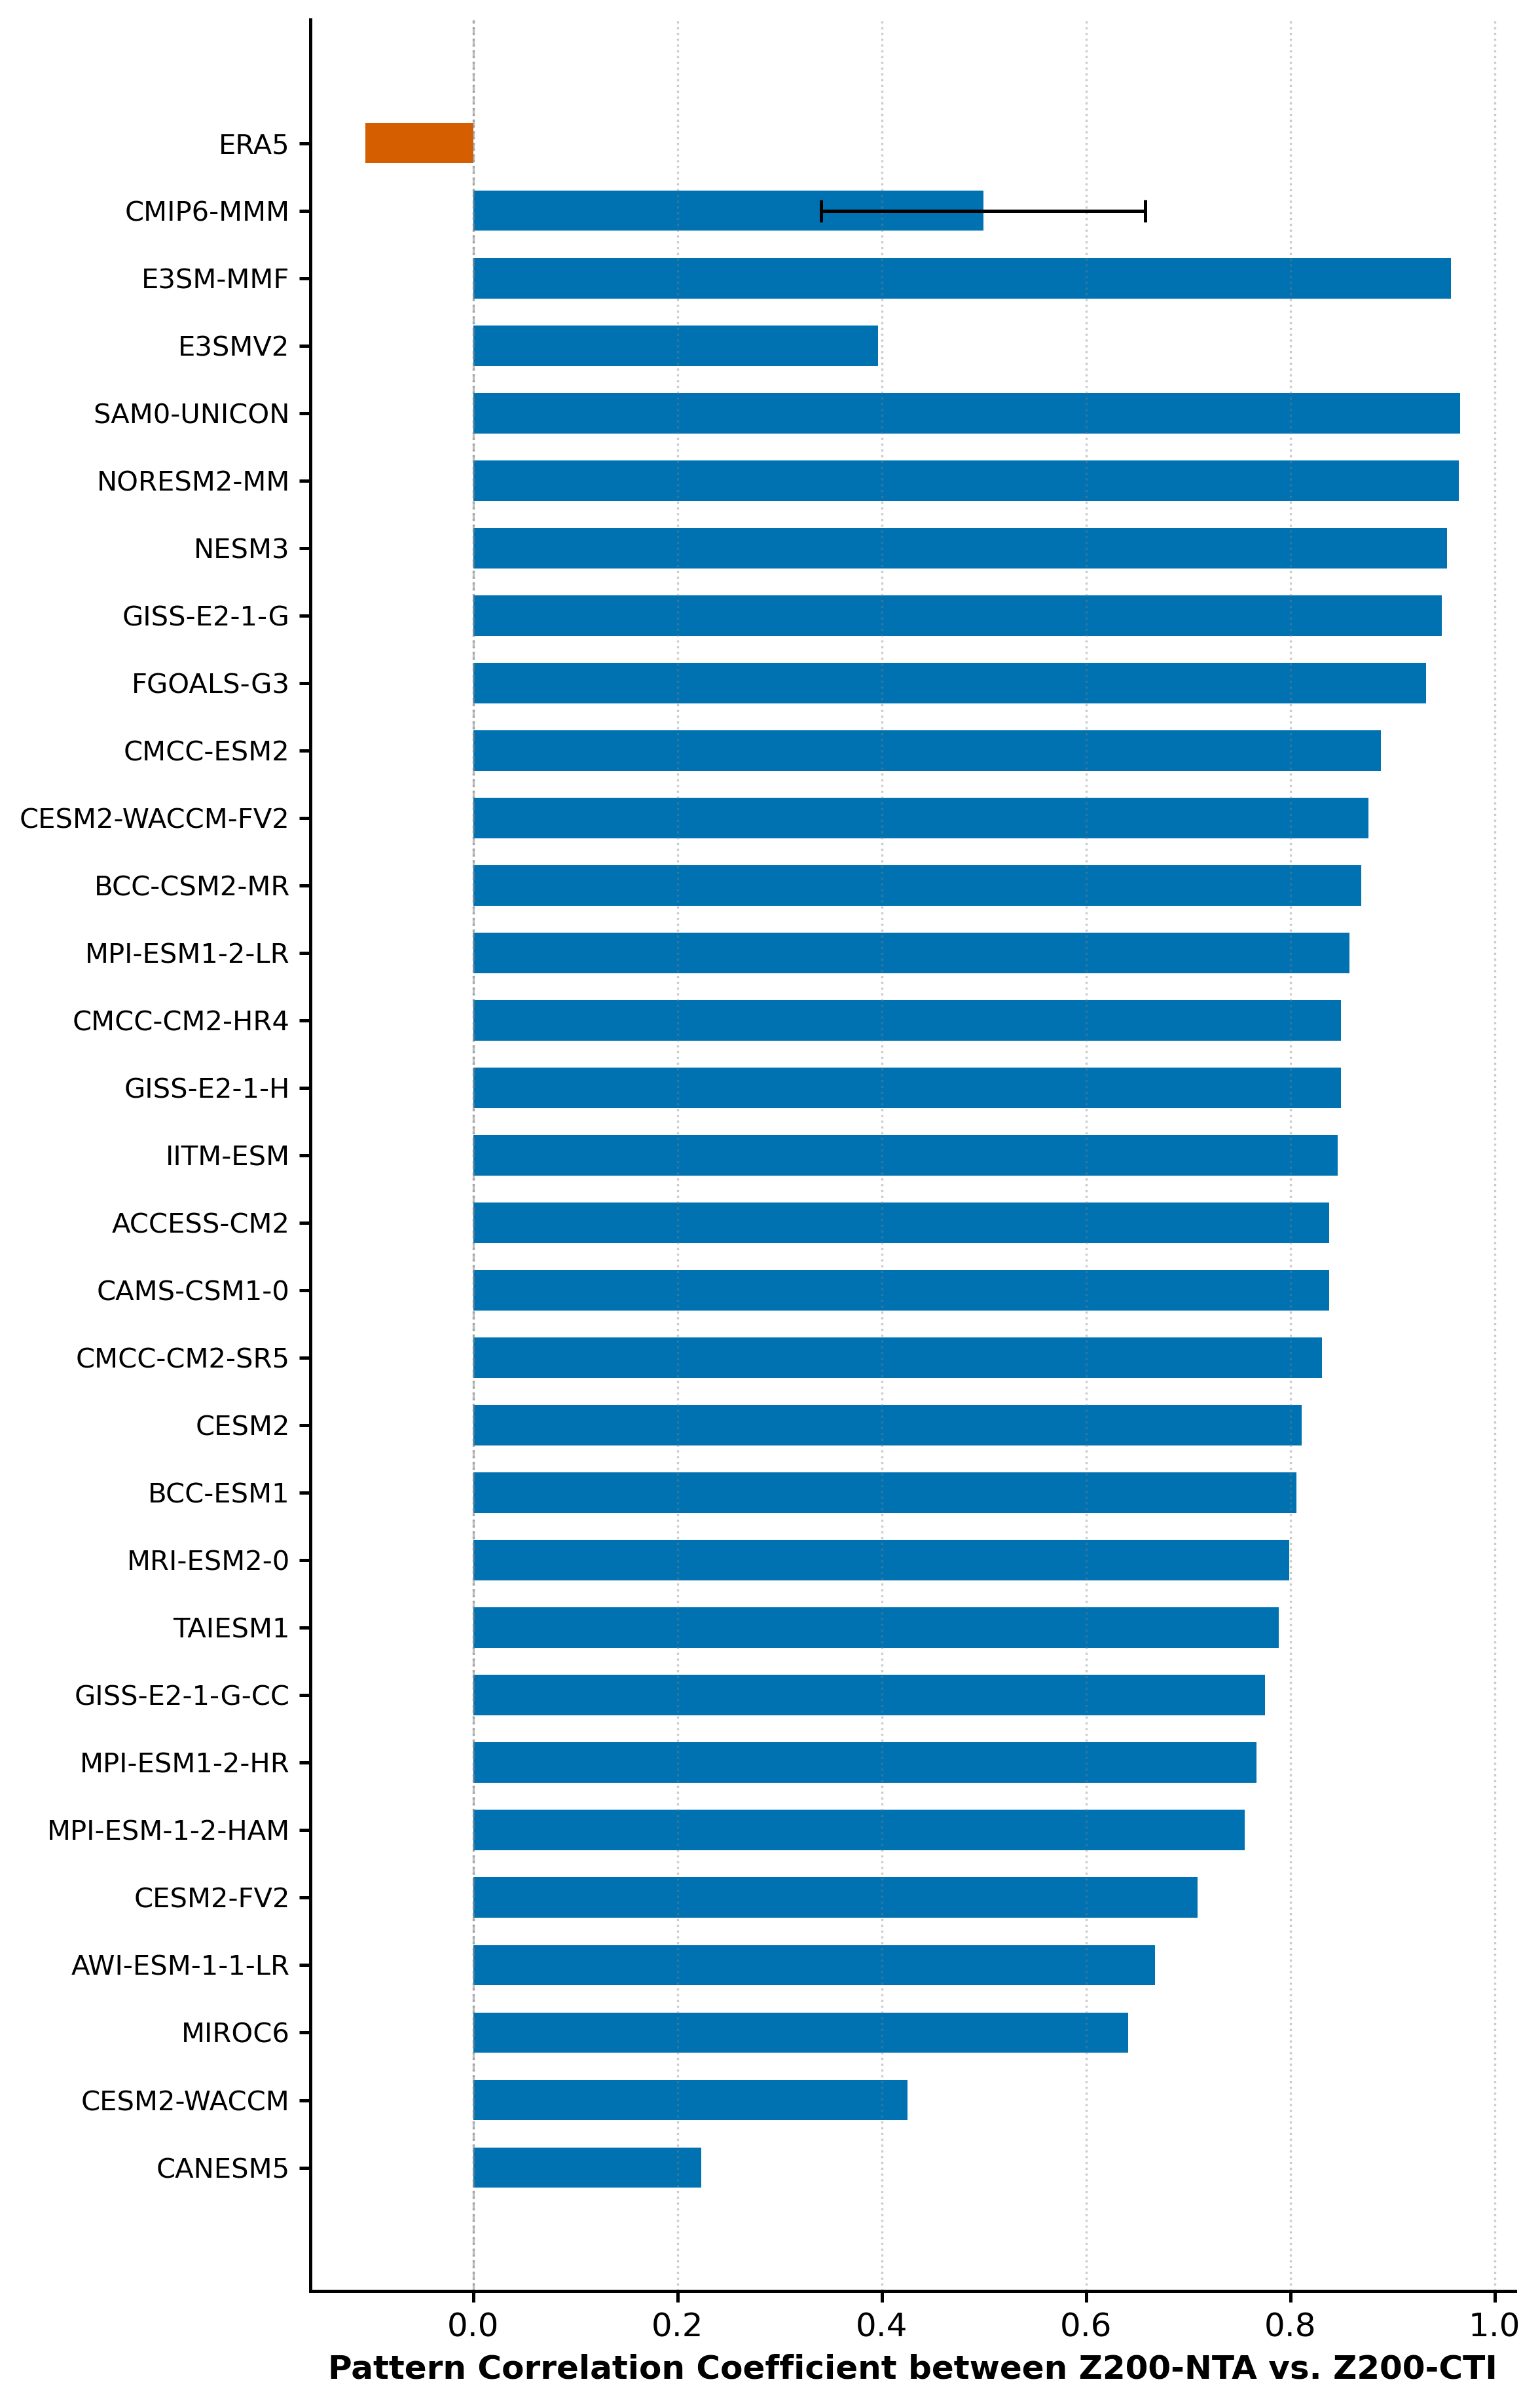

In [19]:
cor_z200['CMIP6-MMM'] = cmip_mmm_cor
print(f"CMIP6-MMM correlation = {cmip_mmm_cor:.3f} ± {cmip_std_cor:.3f}")
plot_pattern_correlations(cor_z200, x_label='Pattern Correlation Coefficient between Z200-NTA vs. Z200-CTI')


In [20]:
# Combine two correlation coefficients to evaluate model performance
def evaluate_model_performance(cor_wc, cor_z200, ref_model='ERA5'):
    # Create dictionaries to store scores
    model_scores = {}
    model_scores_wc = {}
    model_scores_z200 = {}
    
    # Get correlation coefficients for reference model (ERA5)
    ref_wc = cor_wc[ref_model]
    ref_z200 = cor_z200[ref_model]
    
    # Get min and max values for normalization
    wc_values = [v for k,v in cor_wc.items() if k != ref_model and k != 'CMIP6-MMM']
    z200_values = [v for k,v in cor_z200.items() if k != ref_model and k != 'CMIP6-MMM']
    
    wc_min, wc_max = min(wc_values), max(wc_values)
    z200_min, z200_max = min(z200_values), max(z200_values)
    
    # Calculate normalized scores for each model
    for model in cor_wc.keys():
        if model != ref_model and model != 'CMIP6-MMM':
            # Normalize WC and Z200 scores to 0-1 range
            wc_norm = (cor_wc[model] - wc_min) / (wc_max - wc_min)
            z200_norm = (cor_z200[model] - z200_min) / (z200_max - z200_min)
            
            model_scores_wc[model] = wc_norm
            model_scores_z200[model] = z200_norm
            
            # Combined score is sum of normalized values
            model_scores[model] = wc_norm + z200_norm
    
    # Sort by total score (higher is better)
    sorted_models = dict(sorted(model_scores.items(), key=lambda x: x[1], reverse=True))
    
    # Print ranking results
    print("Model Performance Ranking (Based on Normalized WC and Z200 Scores):")
    print("Rank\tModel Name\t\tWC Score\tZ200 Score\tTotal Score")
    print("-" * 75)
    for i, (model, score) in enumerate(sorted_models.items(), 1):
        print(f"{i}\t{model:<15}\t{model_scores_wc[model]:.3f}\t\t{model_scores_z200[model]:.3f}\t\t{score:.3f}")
        
    return sorted_models

# Execute model evaluation
model_ranking = evaluate_model_performance(cor_omega, cor_z200)




Model Performance Ranking (Based on Normalized WC and Z200 Scores):
Rank	Model Name		WC Score	Z200 Score	Total Score
---------------------------------------------------------------------------
1	NorESM2-MM     	1.000		0.998		1.998
2	SAM0-UNICON    	0.986		1.000		1.986
3	E3SM-MMF       	0.931		0.988		1.918
4	FGOALS-g3      	0.963		0.955		1.918
5	GISS-E2-1-G    	0.926		0.976		1.902
6	NESM3          	0.892		0.982		1.875
7	CMCC-ESM2      	0.888		0.896		1.783
8	GISS-E2-1-H    	0.857		0.843		1.700
9	MPI-ESM1-2-LR  	0.801		0.854		1.655
10	CMCC-CM2-SR5   	0.806		0.818		1.623
11	CAMS-CSM1-0    	0.776		0.827		1.604
12	CESM2-FV2      	0.889		0.654		1.542
13	GISS-E2-1-G-CC 	0.795		0.743		1.538
14	CESM2-WACCM-FV2	0.648		0.879		1.527
15	MRI-ESM2-0     	0.743		0.774		1.517
16	TaiESM1        	0.755		0.761		1.516
17	BCC-CSM2-MR    	0.519		0.869		1.388
18	CESM2          	0.575		0.791		1.366
19	MIROC6         	0.791		0.563		1.353
20	CMCC-CM2-HR4   	0.497		0.843		1.339
21	MPI-ESM1-2-HR  	0.602		0.732		1.3

In [ ]:
# save the model ranking
model_ranking.to_csv('../results/tables/model_ranking.csv')

In [22]:
# load the model ranking
df = pd.read_csv('../results/tables/model_ranking.csv', index_col=0)

# group the model into high skill and low skill
high_skill = df[df['Distance'] < 1].index.tolist()
low_skill = df[df['Distance'] > 1.5].index.tolist()

print("High skill models:")
print("-" * 30)
for model in high_skill:
    print(f"{model}: {df.loc[model,'Distance']:.3f}")

print("\nLow skill models:")
print("-" * 30) 
for model in low_skill:
    print(f"{model}: {df.loc[model,'Distance']:.3f}")


高技能模式:
------------------------------
MPI-ESM-1-2-HAM: 0.957
CESM2-WACCM: 0.920
AWI-ESM-1-1-LR: 0.790
E3SMv2: 0.233
CanESM5: 0.026

低技能模式:
------------------------------
NorESM2-MM: 1.998
SAM0-UNICON: 1.986
E3SM-MMF: 1.918
FGOALS-g3: 1.918
GISS-E2-1-G: 1.902
NESM3: 1.875
CMCC-ESM2: 1.783
GISS-E2-1-H: 1.700
MPI-ESM1-2-LR: 1.655
CMCC-CM2-SR5: 1.623
CAMS-CSM1-0: 1.604
CESM2-FV2: 1.542
GISS-E2-1-G-CC: 1.538
CESM2-WACCM-FV2: 1.527
MRI-ESM2-0: 1.517
TaiESM1: 1.516
